In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def cholesky_decomposition(A):
    """
    Compute the Cholesky decomposition of a symmetric positive-definite matrix A = L L^T.
    
    Parameters:
    A : numpy.ndarray
        A symmetric positive-definite matrix of shape (n, n)
        
    Returns:
    L : numpy.ndarray
        Lower triangular matrix such that A = L L^T

    Source: Advance Engineering Mathematics 10th Edition by Erwin Kreyszig, p. 855
    """
    n = A.shape[0]
    L = np.zeros_like(A, dtype=np.float64)
    
    # Check if matrix is square
    if A.shape[0] != A.shape[1]:
        raise ValueError("Matrix must be square")
    
    # Check symmetry (optional but good for validation)
    if not np.allclose(A, A.T):
        raise ValueError("Matrix must be symmetric")
    
    # j = 1 case (first column)
    L[0, 0] = np.sqrt(A[0, 0])
    L[1:, 0] = A[1:, 0] / L[0, 0]
    
    # j = 2 to n
    for j in range(1, n):
        # Diagonal element
        sum_sq = np.sum(L[j, :j]**2)
        L[j, j] = np.sqrt(A[j, j] - sum_sq)
        
        # Off-diagonal elements (p = j+1 to n)
        for p in range(j+1, n):
            sum_prod = np.sum(L[p, :j] * L[j, :j])
            L[p, j] = (A[p, j] - sum_prod) / L[j, j]    # 3rd nested loop in here
    
    return L

In [3]:
def forward_substitution(L, Y):
    """Solve Lz = Y for z (forward substitution)."""
    n = L.shape[0]
    z = np.zeros(n, dtype=np.float64)
    for i in range(n):
        z[i] = (Y[i] - np.dot(L[i, :i], z[:i])) / L[i, i]
    return z

def backward_substitution(LT, z):
    """Solve LTx = z for x (backward substitution)."""
    n = LT.shape[0]
    x = np.zeros(n, dtype=np.float64)
    for i in reversed(range(n)):
        x[i] = (z[i] - np.dot(LT[i, i+1:], x[i+1:])) / LT[i, i]
    return x

def solve_cholesky(B, Y):
    """Solve Bx = Y using Cholesky decomposition."""
    L = cholesky_decomposition(B)
    z = forward_substitution(L, Y)
    x = backward_substitution(L.T, z)
    return x

In [4]:
B = np.array([
        [4,   2,  14],
        [2,  17,  -5],
        [14, -5,  83]
    ], dtype=np.float64)

print(np.linalg.cholesky(B))

L = cholesky_decomposition(B)
print(L)

Y = np.array([14, -101, 155], dtype=np.float64)

# Solve Bx = Y
x = solve_cholesky(B, Y)
print("Solution x:", x)

# Verification: Bx should equal Y
print("Verification (Bx):", np.dot(B, x))

[[ 2.  0.  0.]
 [ 1.  4.  0.]
 [ 7. -3.  5.]]
[[ 2.  0.  0.]
 [ 1.  4.  0.]
 [ 7. -3.  5.]]
Solution x: [ 3. -6.  1.]
Verification (Bx): [  14. -101.  155.]


In [5]:
def expand_polynomial(a0, a1, a2, a3, xj):
    """Convert polynomial from (x-xj) form to standard x form"""
    # q(x) = a0 + a1*(x-xj) + a2*(x-xj)^2 + a3*(x-xj)^3
    # Expanded form: c0 + c1*x + c2*x^2 + c3*x^3
    c0 = a0 - a1*xj + a2*xj**2 - a3*xj**3
    c1 = a1 - 2*a2*xj + 3*a3*xj**2
    c2 = a2 - 3*a3*xj
    c3 = a3
    return [c0, c1, c2, c3]

In [6]:
# Inputs
x_data = [-2, -1, 0, 1, 2]
f_data = [0, 0, 1, 0, 0]
k0 = 0
kn = 0

# Start of main section
x = np.asarray(x_data, dtype=float)
f = np.asarray(f_data, dtype=float)
n = len(x) - 1  # number of intervals

# Verify inputs
if len(x) != len(f):
    raise ValueError("x and f must have the same length")
if n < 2:
    raise ValueError("At least 3 data points required for cubic spline")

# Check if nodes are equidistant
h = np.diff(x)
if not np.allclose(h, h[0]):
    raise ValueError("Nodes must be equidistant for this implementation")
h = h[0]

# Step 1: Solve for k values (first derivatives at nodes)
# Set up the system of equations for interior points
if n > 2:
    # How matrix A is set up:
    #---------------------------------------
    #   k0 + 4*k1 + 1*k2 + 0*k3 + 0*k4 + ...
    # 0*k0 + 1*k1 + 4*k2 + 1*k3 + 0*k4 + ...
    # 0*k0 + 0*k1 + 1*k2 + 4*k3 + 1*k4 + ...
    # ...

    # Put the coefficients in the matrix
    # [[ 4.  1.  0.  0. ...  0.]
    #  [ 1.  4.  1.  0. ...  0.]
    #  [ 0.  1.  4.  1. ...  0.]
    #  [ 0.  0.  1.  4. ...  0.]
    #  [... ... ... ... ... ...]
    #  [ 0. ...  0.  0.  1.  4.]]

    # The resulting matrix is always symmetric.
    # Good case to test Cholesky decomposition,
    # but there is most likely a faster way.

    # EDIT: Thomas alg. is prolly the best out there.
    # Big O notation for these methods:
    # Cholesky decomposition - O(n^3)
    # Thomas algorithm       - O(n)
    # TODO: Construct TDMA() function

    # Create tridiagonal system
    A = np.zeros((n-1, n-1))
    b = np.zeros(n-1)
    
    # Main diagonal (4's)
    np.fill_diagonal(A, 4)
    
    # Sub and super diagonals (1's)
    if n > 3:
        np.fill_diagonal(A[1:], 1)
        np.fill_diagonal(A[:, 1:], 1)
    
    # Right-hand side
    for j in range(1, n):
        b[j-1] = (3/h) * (f[j+1] - f[j-1])
    
    # Adjust first and last equations for boundary conditions
    b[0] -= k0
    b[-1] -= kn
 
    #print(A)

    # Solve the system
    #k_inner = np.linalg.solve(A, b) # Prolly cheating 
    k_inner = solve_cholesky(A, b)
    # k_inner = tdma()
    k = np.concatenate(([k0], k_inner, [kn]))
else:
    # Special case for only 3 points (1 interior point)
    k1 = (3/h) * (f[2] - f[0]) - k0 - kn
    k = np.array([k0, k1, kn])

#print(k)

# Step 2: Calculate coefficients for each spline segment
print( "---------------------------------------------")
print(f"|   j   |   aj0  |   aj1  |   aj2  |   aj3  |")
print( "---------------------------------------------")
splines = []
for j in range(n):
    a0 = f[j]
    #print(a0)
    a1 = k[j]
    #print(a1)
    a2 = (3/h**2) * (f[j+1] - f[j]) - (1/h) * (k[j+1] + 2*k[j])
    #print(a2)
    a3 = (2/h**3) * (f[j] - f[j+1]) + (1/h**2) * (k[j+1] + k[j])
    #print(a3)
    #print("|", j, "|", a0, "|", a1, "|", a2, "|", a3)
    print(f"| {j:3d}   | {a0:5.2f}  | {a1:5.2f}  | {a2:5.2f}  | {a3:5.2f}  |")
    #print(j)

    splines.append({
            'interval': [x[j], x[j+1]],
            'coefficients': [a0, a1, a2, a3],
            'expanded': expand_polynomial(a0, a1, a2, a3, x[j])
        })
print("---------------------------------------------")

#print(splines[0]['interval'])
#print(splines[0]['coefficients'])
#print("Final from (lowest to highest)")
#print(splines[0]['expanded'])

"""Print the spline results in a readable format"""
print("\nCubic Spline Results:")
print("====================")

print("\nSegment Coefficients (q_j(x) = a0 + a1*(x-xj) + a2*(x-xj)^2 + a3*(x-xj)^3):")
for i, s in enumerate(splines):
    print(f"\nSegment {i} (x ∈ [{s['interval'][0]}, {s['interval'][1]}]):")
    print(f"a0{i} = {s['coefficients'][0]:.6f}")
    print(f"a1{i} = {s['coefficients'][1]:.6f}")
    print(f"a2{i} = {s['coefficients'][2]:.6f}")
    print(f"a3{i} = {s['coefficients'][3]:.6f}")

print("\nExpanded Polynomial Forms:")
for i, s in enumerate(splines):
    c = s['expanded']
    print(f"q_{i}(x) = {c[3]:.6f}x³ + {c[2]:.6f}x² + {c[1]:.6f}x + {c[0]:.6f}")

---------------------------------------------
|   j   |   aj0  |   aj1  |   aj2  |   aj3  |
---------------------------------------------
|   0   |  0.00  |  0.00  | -0.75  |  0.75  |
|   1   |  0.00  |  0.75  |  1.50  | -1.25  |
|   2   |  1.00  | -0.00  | -2.25  |  1.25  |
|   3   |  0.00  | -0.75  |  1.50  | -0.75  |
---------------------------------------------

Cubic Spline Results:

Segment Coefficients (q_j(x) = a0 + a1*(x-xj) + a2*(x-xj)^2 + a3*(x-xj)^3):

Segment 0 (x ∈ [-2.0, -1.0]):
a00 = 0.000000
a10 = 0.000000
a20 = -0.750000
a30 = 0.750000

Segment 1 (x ∈ [-1.0, 0.0]):
a01 = 0.000000
a11 = 0.750000
a21 = 1.500000
a31 = -1.250000

Segment 2 (x ∈ [0.0, 1.0]):
a02 = 1.000000
a12 = -0.000000
a22 = -2.250000
a32 = 1.250000

Segment 3 (x ∈ [1.0, 2.0]):
a03 = 0.000000
a13 = -0.750000
a23 = 1.500000
a33 = -0.750000

Expanded Polynomial Forms:
q_0(x) = 0.750000x³ + 3.750000x² + 6.000000x + 3.000000
q_1(x) = -1.250000x³ + -2.250000x² + 0.000000x + 1.000000
q_2(x) = 1.250000x³ + -2.

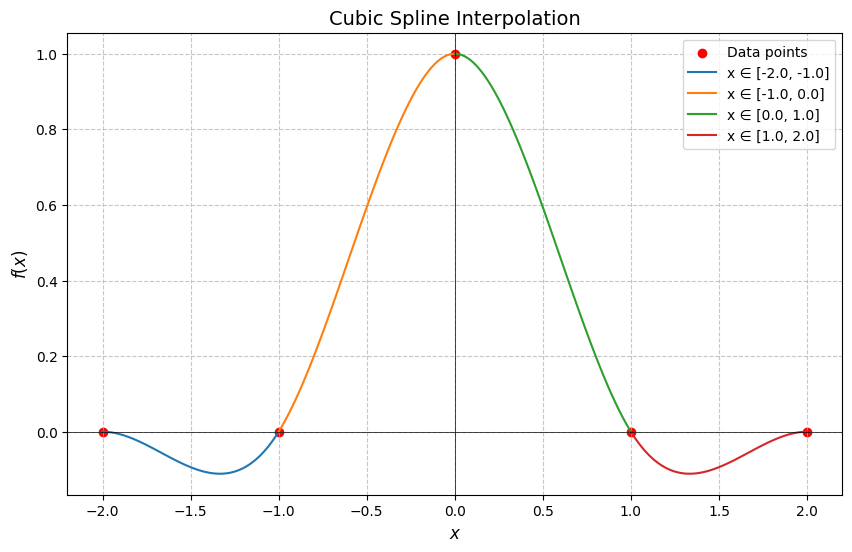

In [7]:
# Create a figure
plt.figure(figsize=(10, 6))
plt.scatter(x_data, f_data, color='red', label='Data points')

# Plot each segment
for s in splines:
    c0, c1, c2, c3 = s['expanded']
    func = lambda x: c3*x**3 + c2*x**2 + c1*x + c0
    xmin, xmax = s['interval']
    #print(xmin)
    x_vals = np.linspace(xmin, xmax, 100)    
    plt.plot(x_vals, func(x_vals), label=f'x ∈ [{xmin}, {xmax}]')

plt.title('Cubic Spline Interpolation', fontsize=14)

# Plots from example
#xmin1, xmax1 = -1, 0
#tt = np.linspace(xmin1, xmax1, 100)    
#qq1 = lambda x: -1.25*x**3 - 2.25*x**2 - 1.5*x - 0.5
#plt.plot(tt, qq1(x_vals), label=f'x ∈ [{xmin}, {xmax}]')
#
#xmin2, xmax2 = 0, 1
#tt = np.linspace(xmin2, xmax2, 100)    
#qq2 = lambda x: 1.25*x**3 - 3.75*x**2 - 1.0
#plt.plot(tt, qq2(x_vals), label=f'x ∈ [{xmin}, {xmax}]')

plt.xlabel('$x$', fontsize=12)
plt.ylabel('$f(x)$', fontsize=12)
plt.legend(fontsize=10)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.7)

## Possible mistakes in the example file
In the table $a_{22}$ should be -2.25.

In [8]:
# Manual check
3/1*(0-1) - 1/1*(-3/4 +2*0)

-2.25

### Additional checks using SymPy

In [9]:
import sympy as sy
from IPython.display import display

x = sy.Symbol("x")
q1 = 0 + 0.75*(x -(-1)) + 1.5*(x -(-1))**2 + (-1.25)*(x - (-1))**3
sy.expand(q1)

-1.25*x**3 - 2.25*x**2 + 1.0

### More mistakes visible here

In [10]:
for i in range(n):
    C = splines[i]['coefficients']
    X = splines[i]['interval']
    q = C[0] + C[1]*(x - X[0]) + C[2]*(x - X[0])**2 + C[3]*(x - X[0])**3
    #sy.pprint(sy.expand(q))
    display(sy.expand(q))

0.75*x**3 + 3.75*x**2 + 6.0*x + 3.0

-1.25*x**3 - 2.25*x**2 + 1.0

1.25*x**3 - 2.25*x**2 - 5.73316704659901e-17*x + 1.0

-0.75*x**3 + 3.75*x**2 - 6.0*x + 3.0

### Suggested fix
$$
g(x)=\left\{\begin{array}{l}
0.75 x^3 + 3.75 x^2 + 6 x + 3, \quad x \in[-2,-1), \\
-1.25 x^3 - 2.25 x^2 + 1, \quad x \in[-1,0), \\
1.25 x^3 - 2.25 x^2 + 1, \quad x \in[0,1), \\
-0.75 x^3 + 3.75 x^2 - 6 x + 3, \quad x \in[1,2] .
\end{array}\right.
$$